In [1]:
# import all the required libraries

import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
%matplotlib inline
sns.set_color_codes()

from sklearn.preprocessing import StandardScaler
from scipy.stats import zscore
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import cophenet, dendrogram, linkage
from scipy.spatial.distance import pdist
from sklearn.cluster import AgglomerativeClustering 
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA

In [2]:
# read the data
customer = pd.read_excel('Credit Card Customer Data.xlsx')

# print shape
display(customer.shape)

# take a look at the dataframe using head

display(customer.head())

(660, 7)

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
0,1,87073,100000,2,1,1,0
1,2,38414,50000,3,0,10,9
2,3,17341,50000,7,1,3,4
3,4,40496,30000,5,1,1,4
4,5,47437,100000,6,0,12,3


### from head it looks like SI No and Customer Key are primary keys. Also we see Avg Credit Limit has very large values compared to other columns so we would have to do scaling.

## EDA 15 Marks

In [3]:
# do a info to look at the datatypes 
customer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 660 entries, 0 to 659
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype
---  ------               --------------  -----
 0   Sl_No                660 non-null    int64
 1   Customer Key         660 non-null    int64
 2   Avg_Credit_Limit     660 non-null    int64
 3   Total_Credit_Cards   660 non-null    int64
 4   Total_visits_bank    660 non-null    int64
 5   Total_visits_online  660 non-null    int64
 6   Total_calls_made     660 non-null    int64
dtypes: int64(7)
memory usage: 36.2 KB


### From info we can see all relevant columsn are intger types and and from the column names it looks like all relevent columns are continous integer variables

In [4]:
# check if the Customer Key is a primary index 
display(customer['Customer Key'].nunique())

# figure out the Customer key with multiple values
customer['Customer Key'].value_counts()[:6]

655

47437    2
37252    2
97935    2
96929    2
50706    2
75775    1
Name: Customer Key, dtype: int64

In [5]:
# look at the keys with multiple occurences
customer[customer['Customer Key'].isin([47437,37252,97935,96929,50706])].sort_values('Customer Key')

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made
48,49,37252,6000,4,0,2,8
432,433,37252,59000,6,2,1,2
4,5,47437,100000,6,0,12,3
332,333,47437,17000,7,3,1,0
411,412,50706,44000,4,5,0,2
541,542,50706,60000,7,5,2,2
391,392,96929,13000,4,5,0,0
398,399,96929,67000,6,2,2,2
104,105,97935,17000,2,1,2,10
632,633,97935,187000,7,1,7,0


#### From the head we can see that columsn S1_NO and Customer key are acting like primary keys and we dont need to include these in our analysis. Also we can see that some customer keys are repeacted multiple time but they are not duplicates so I decided not to remove those assuming that it may be possible to have same customer key for two accounts

In [6]:
# check if there are any missing value in the data

customer.isna().sum()

Sl_No                  0
Customer Key           0
Avg_Credit_Limit       0
Total_Credit_Cards     0
Total_visits_bank      0
Total_visits_online    0
Total_calls_made       0
dtype: int64

In [7]:
# Use describe method to found out min , max , quartiles , standard deviation and meean

customer.describe().T

,count,mean,std,min,25%,50%,75%,max
Sl_No,660.0,330.500000,190.669872,1.0,165.75,330.5,495.25,660.0
Customer Key,660.0,55141.443939,25627.772200,11265.0,33825.25,53874.5,77202.50,99843.0
Avg_Credit_Limit,660.0,34574.242424,37625.487804,3000.0,10000.00,18000.0,48000.00,200000.0
Total_Credit_Cards,660.0,4.706061,2.167835,1.0,3.00,5.0,6.00,10.0
Total_visits_bank,660.0,2.403030,1.631813,0.0,1.00,2.0,4.00,5.0
Total_visits_online,660.0,2.606061,2.935724,0.0,1.00,2.0,4.00,15.0
Total_calls_made,660.0,3.583333,2.865317,0.0,1.00,3.0,5.00,10.0


### From null values analyis and  describe method we can see there is no hidden missing values in the data. Total credit card minimum value is 1 which is correct. Visit and call related min value is 0 which is possible. 

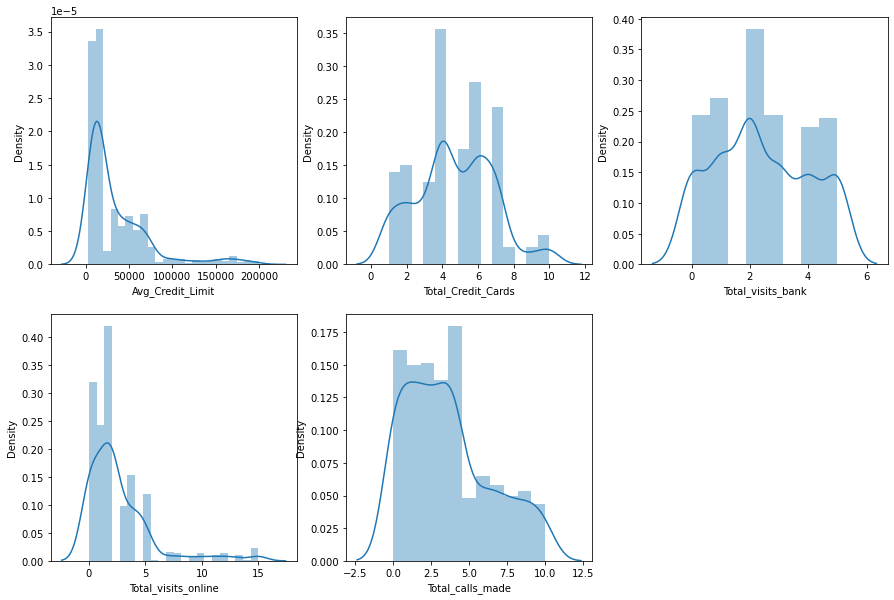

In [8]:
plt.figure(figsize= (15,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback =  list(customer.columns)[2:]

for i in feedback:
    plt.subplot(2, 3, pos)
    sns.distplot(customer[i])
    pos += 1  # to plot over the grid one by one  

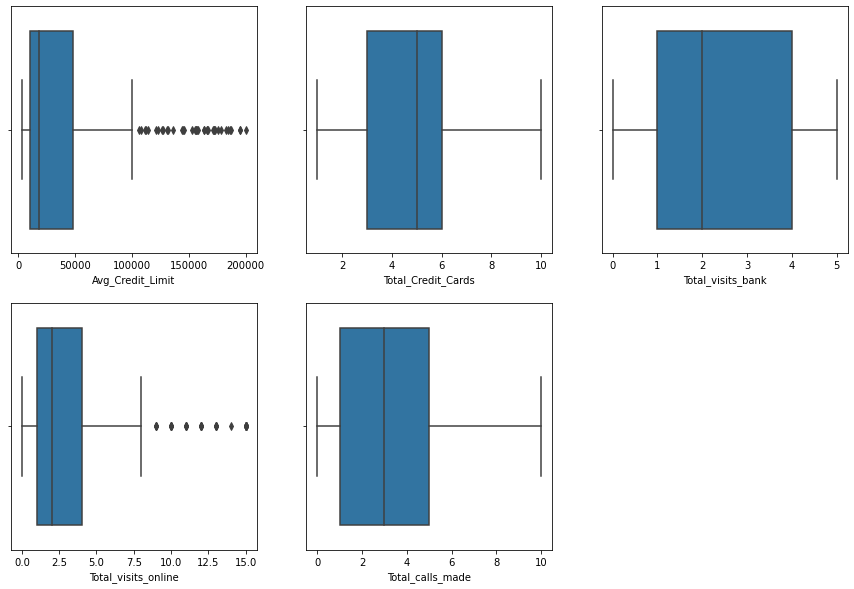

In [9]:
plt.figure(figsize= (15,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback =  list(customer.columns)[2:
                                  
                                  ]

for i in feedback:
    plt.subplot(2, 3, pos)
    sns.boxplot(customer[i])
    pos += 1  # to plot over the grid one by one  

### From the kernel density plot and we can see a avg_credit_limit and total_visits_online has skewed distribution. From box plot we confirm these are outliers. I decided to remove those outliers by capping those to upper limit of Q3 +   IQR*1.5

In [10]:
for i in ['Avg_Credit_Limit','Total_visits_online']: # looping for two skewed columns
    Q1 = customer[i].quantile(0.25) # find Q1
    Q3 = customer[i].quantile(0.75) # find Q3
    IQR = Q3 - Q1 # calucualte IQR
    up_limit = Q3 + 1.5*IQR # cal upper limit 
    customer[i] = customer.apply(lambda x : up_limit if x[i] > up_limit else x[i] , axis = 1) # apply the changes using lambda function

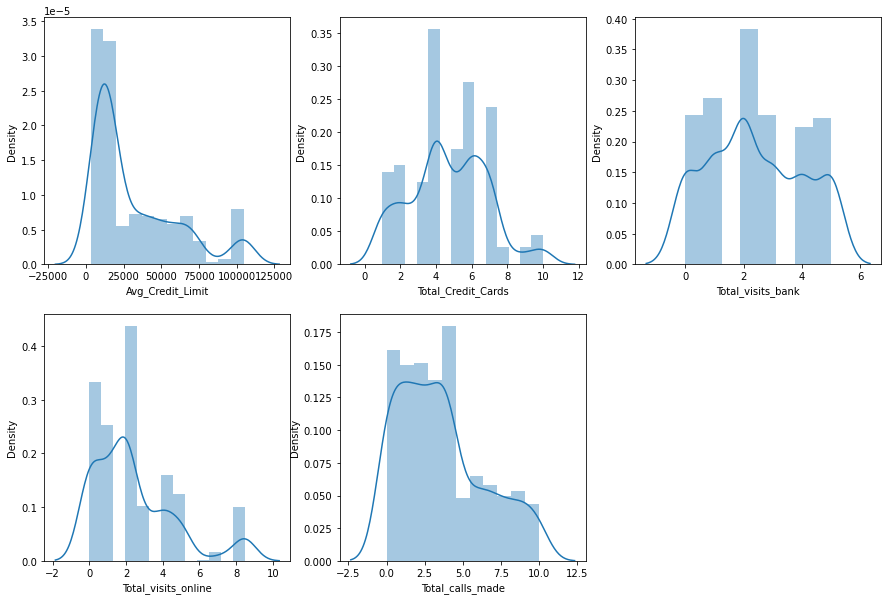

In [11]:
# Replot the kernel density plot

plt.figure(figsize= (15,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback =  list(customer.columns)[2:]

for i in feedback:
    plt.subplot(2, 3, pos)
    sns.distplot(customer[i])
    pos += 1  # to plot over the grid one by one 

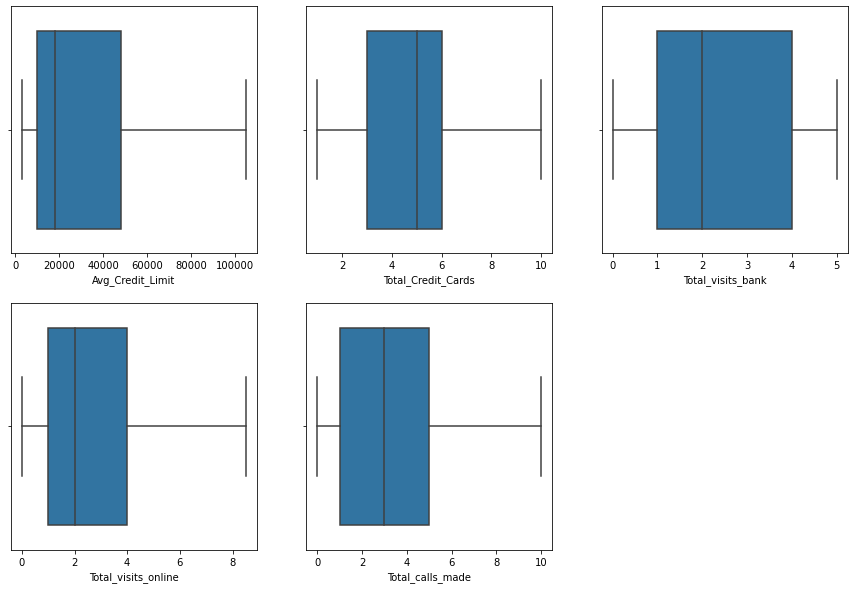

In [12]:
# Replot the box plot
plt.figure(figsize= (15,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback =  list(customer.columns)[2:]

for i in feedback:
    plt.subplot(2, 3, pos)
    sns.boxplot(customer[i])
    pos += 1  # to plot over the grid one by one  

### In the outlier treatment I have capped the very high values with the Q3 +  1.5xIQR value. This is going to change the distribution and it makes some columns bimodal. But I will go ahead with it and make an assumption and  I will treat those as very high cases.

### After outlier treatment and re-looking at distribution plot and box plots I can see the distribution is no longer skewd and outliers are removed.

<AxesSubplot:>

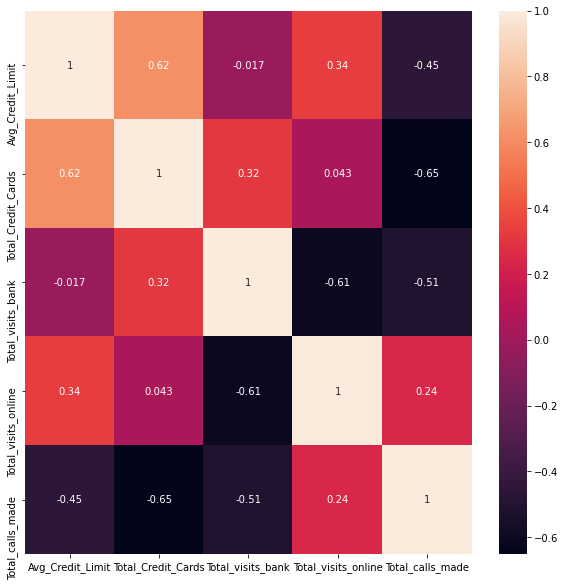

In [13]:
# build a heat map of correlation
plt.figure(figsize= (10,10))
sns.heatmap(customer[customer.columns[2:]].corr(), annot=True)

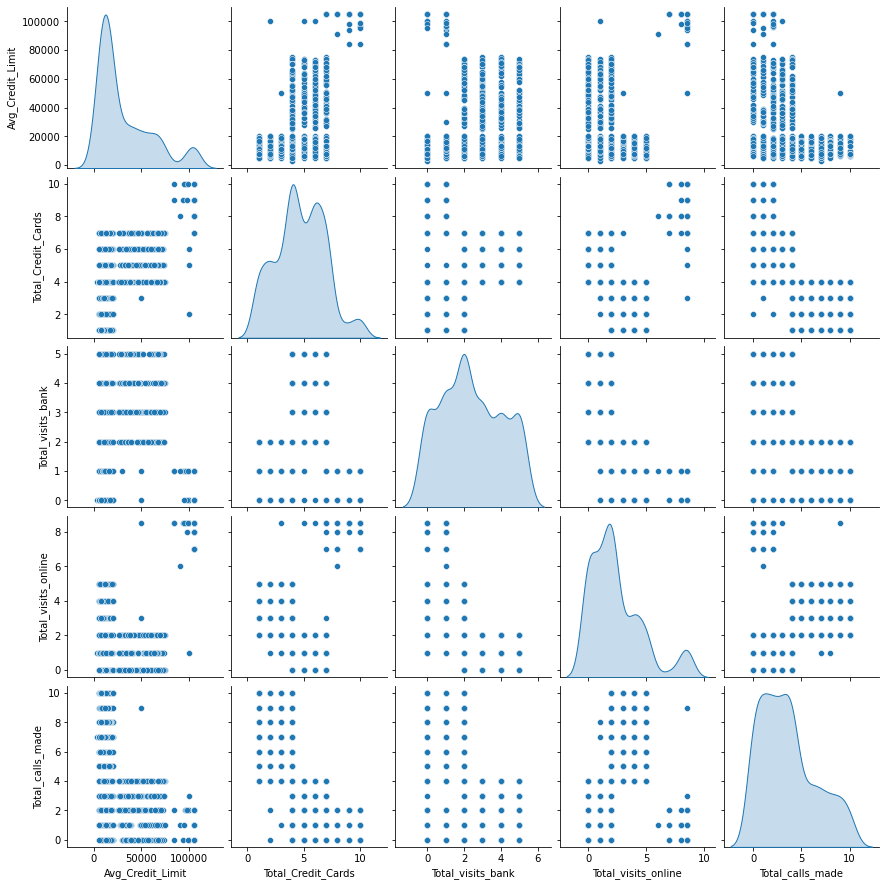

In [14]:
# use seaborn pairplot 
sns.pairplot(customer[customer.columns[2:]],diag_kind='kde')

### 1. Avg credit limit and no of cards are higly correlated. This suggest more the users with high avg limit tend to have more cards

### 2. Users with very high avg limit tend to visit bank less and same is the case with calls. Also these users prefer online.

### 3. It looks from distribution very high avg limit users are small proportion of the credit card holders which is natural. 

### 4. Low avg limit users make more calls, has relatively less online inquries.

### 5. It looks like users who visit bank more use less online and calls. May be they are traditional users or old people but not sure.


### 6. Majorly we can see high ave limit customer goes to online more, medium ones goes to bank more and lower end ones prefer call more. From this is looks like 3 clusters may do the job but not sure. Need to do some statistical drill down to be sure.

## Perform standar scaling

In [15]:
customerz = customer[customer.columns[2:]].apply(zscore)

## Execute K-means clustering use elbow plot and analyse clusters using boxplot (10 marks)

Text(0.5, 1.0, 'Selecting k with the Elbow Method')

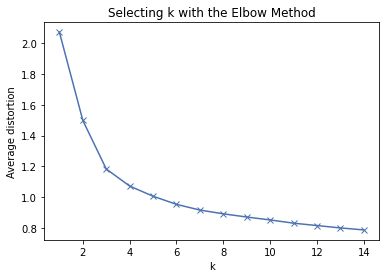

In [16]:
#Finding optimal no. of clusters
from scipy.spatial.distance import cdist
clusters=range(1,15)
meanDistortions=[]

for k in clusters:
    model=KMeans(n_clusters=k)
    model.fit(customerz)
    prediction=model.predict(customerz)
    meanDistortions.append(sum(np.min(cdist(customerz, model.cluster_centers_, 'euclidean'), axis=1)) / customerz
                           .shape[0])


plt.plot(clusters, meanDistortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Average distortion')
plt.title('Selecting k with the Elbow Method')

### From the elbow method I see 3 clusters as optimal since the decrease in average distortion slows down after 3 clusters

In [17]:
for i in range(2,10):
    model = KMeans(n_clusters=i, n_init = 15, random_state=2345)
    model.fit(customerz)
    customer['km_labels'] = model.labels_
    print("K=",i,"-",silhouette_score(customerz, customer['km_labels']))

K= 2 - 0.4201583924929177
K= 3 - 0.5169867470092899
K= 4 - 0.38147048130671246
K= 5 - 0.35332888701008774
K= 6 - 0.271387209779717
K= 7 - 0.2675751507225948
K= 8 - 0.2585495689162854
K= 9 - 0.24940647618763248


### The selection of 3 from elbow is further validated by silhouette_score

In [18]:
#Set the value of k=4
kmeans = KMeans(n_clusters=3, n_init = 15, random_state=2345)

In [19]:
kmeans.fit(customerz)

KMeans(n_clusters=3, n_init=15, random_state=2345)

In [20]:
customer['km_labels'] = kmeans.labels_

In [21]:
customer['km_labels'].value_counts()

1    386
0    224
2     50
Name: km_labels, dtype: int64

### Using box plots to analyse the clusters

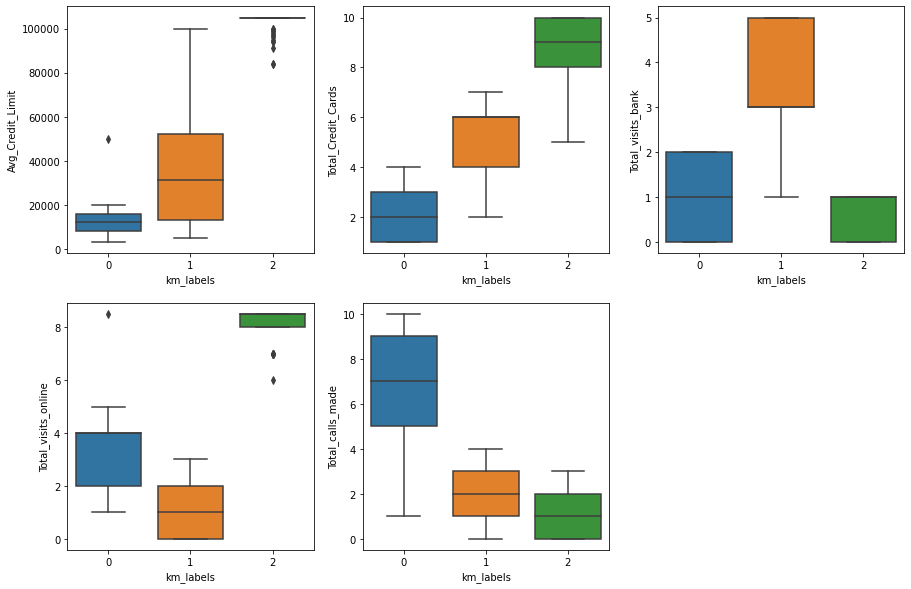

In [22]:
plt.figure(figsize= (15,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback =  list(customer.columns)[2:-1]

for i in feedback:
    plt.subplot(2, 3, pos)
    sns.boxplot(x="km_labels", y=i, data=customer)
    pos += 1 

### Insights of clusters from box plots

### Cluster 2 : We see a clear distinction from rest of the clusters. This cluster has customers with very High Average Credit Limit and huge number of credit cards. Also they visit the bank least. They visit online most. They make least calls. So these segments of customers should be targeted for online Marketing. Since they are high end customer , we can motivate then to do more transaction by providing them various offers and discounts.

### Cluster 1 : The customers in this cluster has Medium to High Average Credit Limit. They have medium to high number of credit cards. They have low presence on calls and online. But they visit the bank a lot. So these customers may not be suitable for online and call marketing. They can be marketed when they visit the bank in person. Since they are also medium to high end customer having high credit limit, they can me motivated to do more transactions.

### Cluster 0 : These customers are low end customers in terms of low average credit limit. Also they visit the bank less and have a moderate online presence. But they have a very high usage of calls. So these segment of customers should be heavily targeted for call based marketing. Since they also have moderate online presence some level of online marketing can be done. Also based on their credit card usage they can be potential customers for which credit limit may be increased. 

## Execute hierarchical clustering (with different linkages) with the help of dendrogram and cophenetic coeff. Analyse clusters formed using boxplot (15 marks)

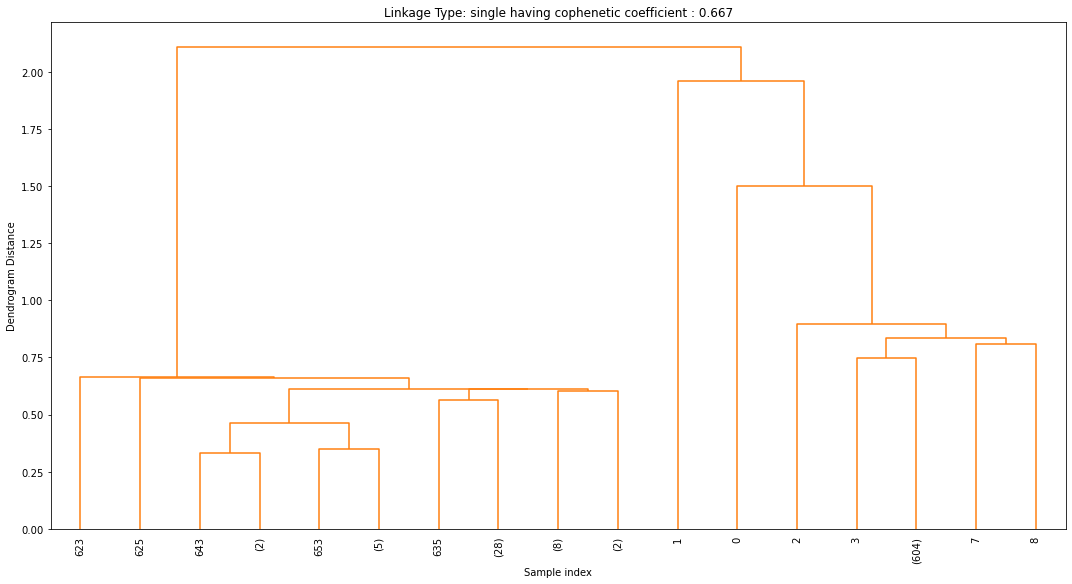

single 0.6666982080229052


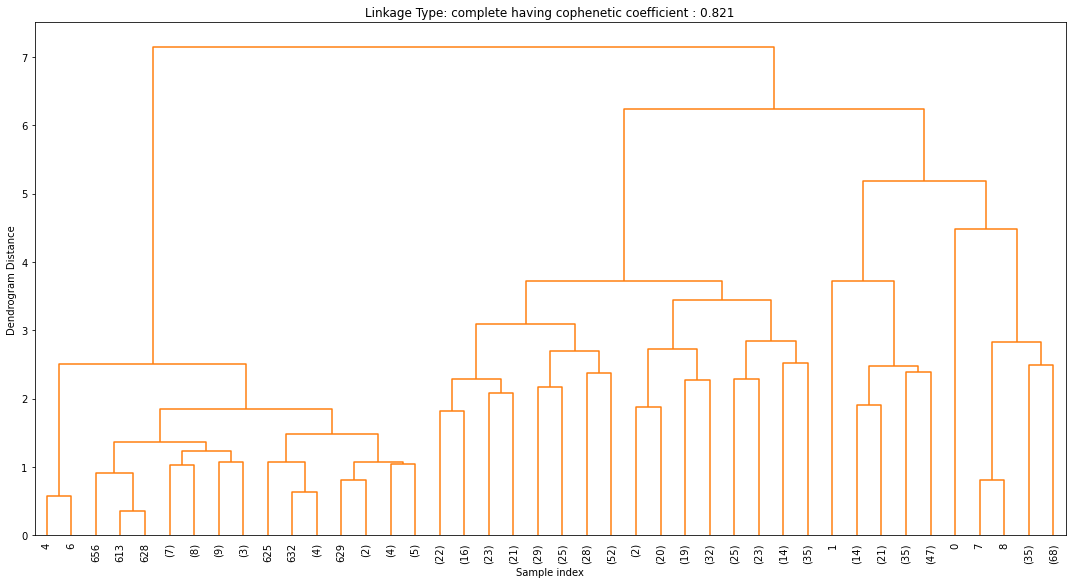

complete 0.8207884321476555


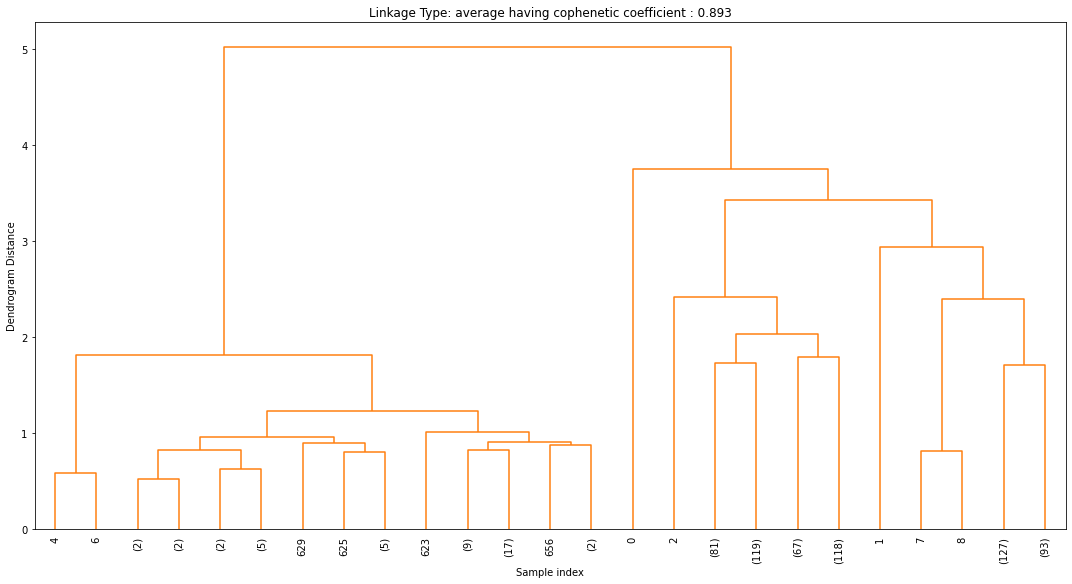

average 0.8926672966587861


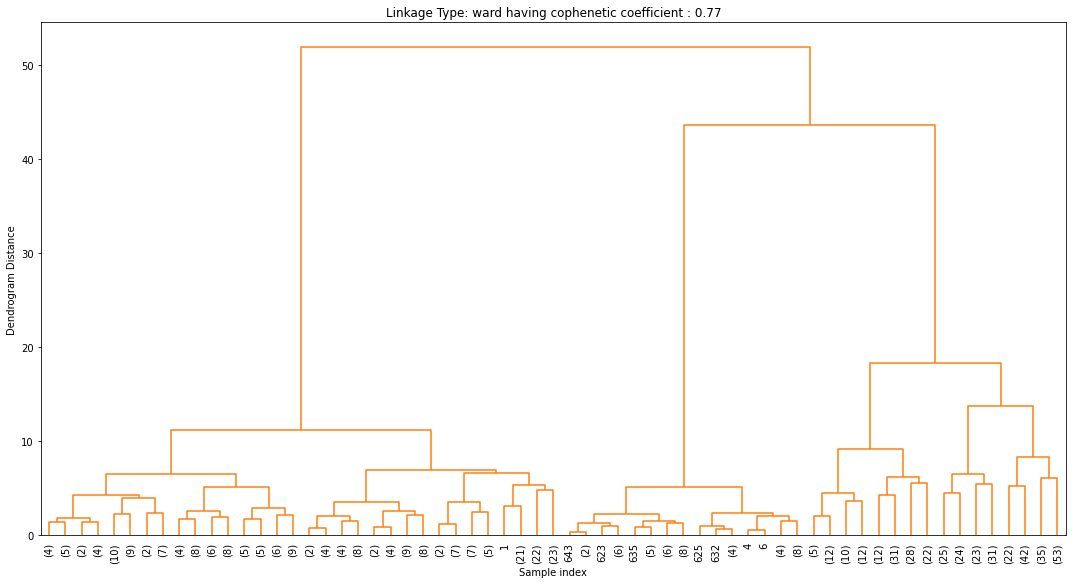

ward 0.7702265240776373


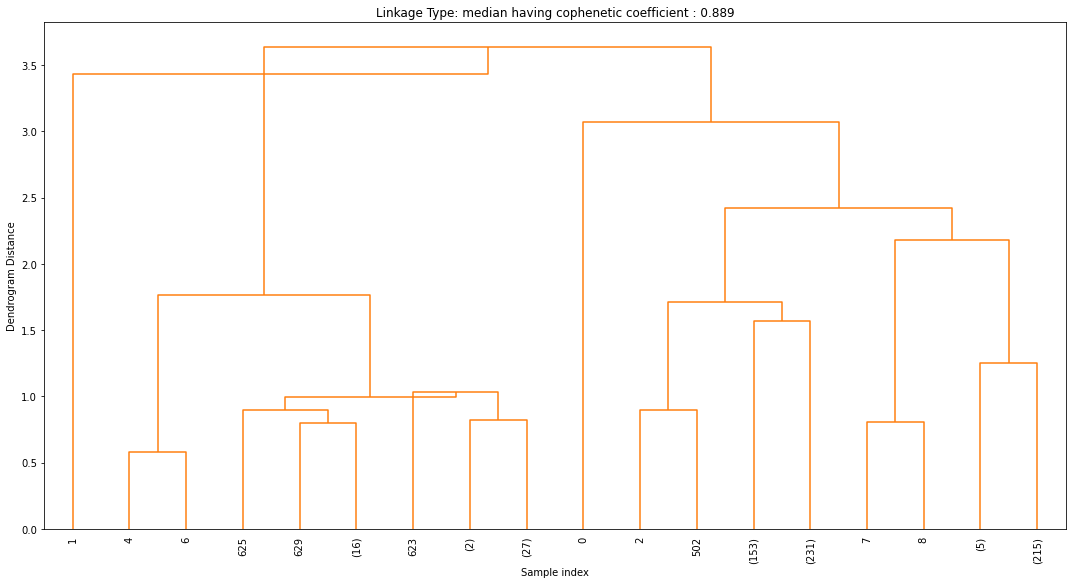

median 0.8887160179419454


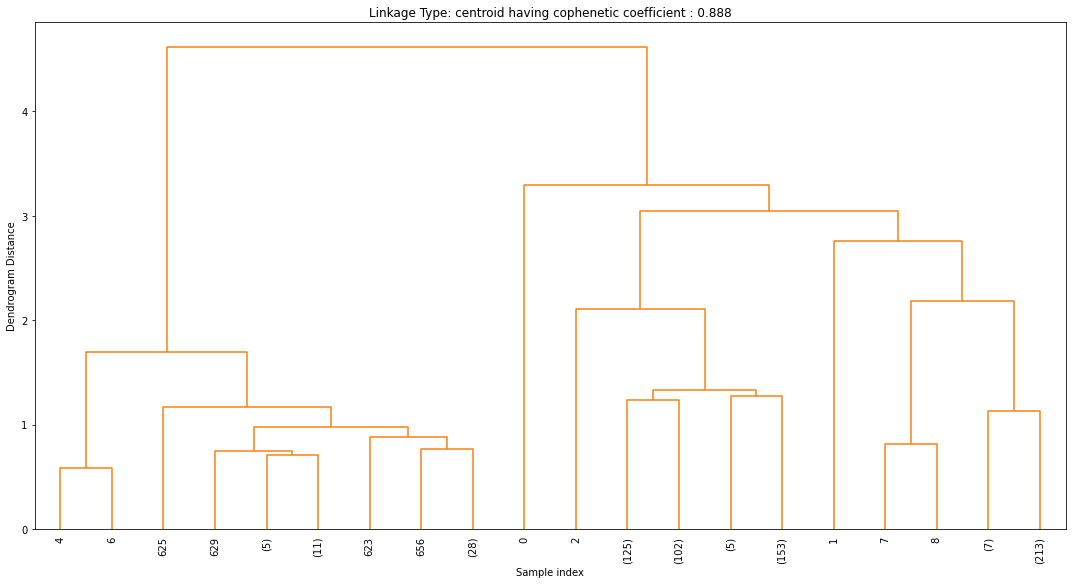

centroid 0.8880634847869346


In [23]:
linkage_methods=['single','complete','average','ward','median', 'centroid']

results_cophenetic_coef=[]

for i in linkage_methods:
    
    plt.figure(figsize=(15, 8))
    
    plt.xlabel('Sample index')
    plt.ylabel('Dendrogram Distance')
    
    Z = linkage(customerz, i)  
    
    cc,cophn_dist=cophenet(Z,pdist(customerz))
    
    dendrogram(Z,leaf_rotation=90.0,p=5,leaf_font_size=10,truncate_mode='level',color_threshold=60)
       
    
    plt.tight_layout()
    
    plt.title("Linkage Type: "+ i +" having cophenetic coefficient : "+str(round(cc,3)) )
    
    plt.show()
    results_cophenetic_coef.append((i,cc))
    print (i,cc)

In [24]:
results_cophenetic_coef_df=pd.DataFrame(results_cophenetic_coef,columns=['LinkageMethod','CopheneticCoefficient'])
results_cophenetic_coef_df

,LinkageMethod,CopheneticCoefficient
0,single,0.666698
1,complete,0.820788
2,average,0.892667
3,ward,0.770227
4,median,0.888716
5,centroid,0.888063


In [25]:
for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i, affinity='euclidean',  linkage='average')
    model.fit(customerz)
    customer['h_labels'] = model.labels_
    print("K=",i,"-",silhouette_score(customerz, customer['h_labels']))

K= 2 - 0.5172480049319457
K= 3 - 0.3442527725855535
K= 4 - 0.4808223272655649
K= 5 - 0.4448661673623261
K= 6 - 0.3184583024863396
K= 7 - 0.2679214686687222
K= 8 - 0.25246208657976804
K= 9 - 0.23295377560327554


In [26]:
model = AgglomerativeClustering(n_clusters=4, affinity='euclidean',  linkage='average')
model.fit(customerz)
customer['h_labels'] = model.labels_
customer['h_labels'].value_counts()

1    386
0    223
3     50
2      1
Name: h_labels, dtype: int64

### Since average linckage has the best CopheneticCoefficient , I checked dendogram and  silhouette_score for average linckages and it looked 4 is the optimal option. But one of the cluster has only 1 item which doesnt make much use case for business point of view. Lets try some other linckages

In [27]:
for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i, affinity='euclidean',  linkage='complete')
    model.fit(customerz)
    customer['h_labels'] = model.labels_
    print("K=",i,"-",silhouette_score(customerz, customer['h_labels']))

K= 2 - 0.5172480049319457
K= 3 - 0.5161199988919521
K= 4 - 0.3670615126997066
K= 5 - 0.3399683865195568
K= 6 - 0.3389466426828615
K= 7 - 0.2441712105645378
K= 8 - 0.21643808014717028
K= 9 - 0.21593054286565214


In [28]:
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')
model.fit(customerz)
customer['h_labels'] = model.labels_
customer['h_labels'].value_counts()

2    386
0    224
1     50
Name: h_labels, dtype: int64

### Complete linkage from dendogram and silhouette_score suggest 3 clusters and distribution mostly matches with average linkage just the one item cluster is adjusted. I decided to go with complete with 3 clusters and its almost similar with average with 4 clusters

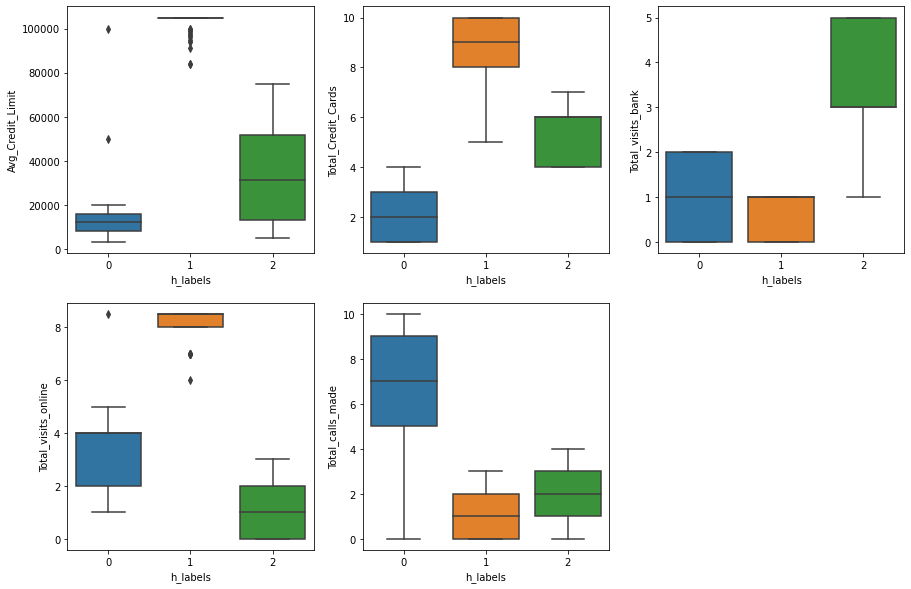

In [29]:
plt.figure(figsize= (15,10))  # setting the figure size
pos = 1  # we will use this variable to index each of the plots
feedback =  list(customer.columns)[2:-2]

for i in feedback:
    plt.subplot(2, 3, pos)
    sns.boxplot(x="h_labels", y=i, data=customer)
    pos += 1 

### Insights of clusters from box plots

### Cluster 1 : We see a clear distinction from rest of the clusters. This cluster has customers with very High Average Credit Limit and huge number of credit cards. Also they visit the bank least. They visit online most. They make least calls. So these segments of customers should be targeted for online Marketing. Since they are high end customer , we can motivate then to do more transaction by providing them various offers and discounts. 

### Cluster 2 : The customers in this cluster has Medium to High Average Credit Limit. They have medium to high number of credit cards. They have low presence on calls and online. But they visit the bank a lot. So these customers may not be suitable for online and call marketing. They can be marketed when they visit the bank in person. Since they are also medium to high end customer having high credit limit, they can me motivated to do more transactions.

### Cluster 0 : These customers are low end customers in terms of low average credit limit. Also they visit the bank less and have a moderate online presence. But they have a very high usage of calls. So these segment of customers should be heavily targeted for call based marketing. Since they also have moderate online presence some level of online marketing can be done. Also based on their credit card usage they can be potential customers for which credit limit may be increased. 

## Calculate average silhouette score for both methods. (5marks)

In [30]:
# silhouette_score for Hierarchical
for i in range(2,10):
    model = AgglomerativeClustering(n_clusters=i, affinity='euclidean',  linkage='complete')
    model.fit(customerz)
    customer['labels'] = model.labels_
    print("K=",i,"-",silhouette_score(customerz, customer['labels']))

K= 2 - 0.5172480049319457
K= 3 - 0.5161199988919521
K= 4 - 0.3670615126997066
K= 5 - 0.3399683865195568
K= 6 - 0.3389466426828615
K= 7 - 0.2441712105645378
K= 8 - 0.21643808014717028
K= 9 - 0.21593054286565214


In [31]:
# silhouette_score for KMeans
for i in range(2,10):
    model = KMeans(n_clusters=i, n_init = 15, random_state=2345)
    model.fit(customerz)
    customer['labels'] = model.labels_
    print("K=",i,"-",silhouette_score(customerz, customer['labels']))

K= 2 - 0.4201583924929177
K= 3 - 0.5169867470092899
K= 4 - 0.38147048130671246
K= 5 - 0.35332888701008774
K= 6 - 0.271387209779717
K= 7 - 0.2675751507225948
K= 8 - 0.2585495689162854
K= 9 - 0.24940647618763248


### Silhouette_score for Hierarchical and KMEANS peak at cluster 3 with almost simialr scores. This suggests using 3 clusters is good estimate for both the clustering algorithms. 

### we can also infer that for number of clusters 4 and 5 K-Means looks slightly better. For 6 Hierarchical looks better

## Compare K-means clusters with Hierarchical clusters. (5 marks)

In [32]:
pca=PCA()

principalComponents = pca.fit_transform(customerz)

variance=pca.explained_variance_ratio_

print("Variance explained by each component")

j=1
for i in variance:
    print("PC",j,":",(i*100))
    j+=1

Variance explained by each component
PC 1 : 47.196473164300926
PC 2 : 34.519351183707364
PC 3 : 6.514193694322347
PC 4 : 6.2132653552804
PC 5 : 5.556716602388968


### I decided to use PCA so that we can visualise in 2D the two algortims. Will take 2 components as its explaining over 80 % of variance

In [33]:
pca=PCA(n_components=2) # make a PCA construct with 2 component

principalComponents = pca.fit_transform(customerz) # fit 

pca_std = pd.DataFrame(data = principalComponents # make a dataframe for pricipal component
             , columns = ['pc1', 'pc2'])


<AxesSubplot:xlabel='pc1', ylabel='pc2'>

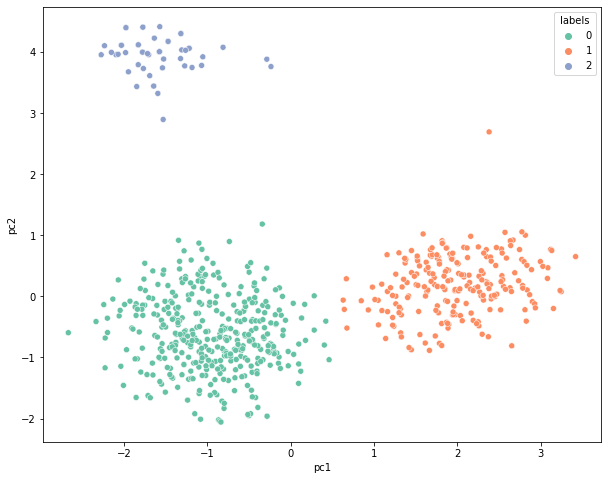

In [34]:
# First try KMEANS with 3 clusters as we used above 
model = KMeans(n_clusters=3, n_init = 15, random_state=2345) # 
model.fit(pca_std)
customer['labels'] = model.labels_
plt.figure(figsize=(10,8))
sns.scatterplot(x=pca_std.pc1, y=pca_std.pc2, hue=customer['labels'], palette="Set2")

<AxesSubplot:xlabel='pc1', ylabel='pc2'>

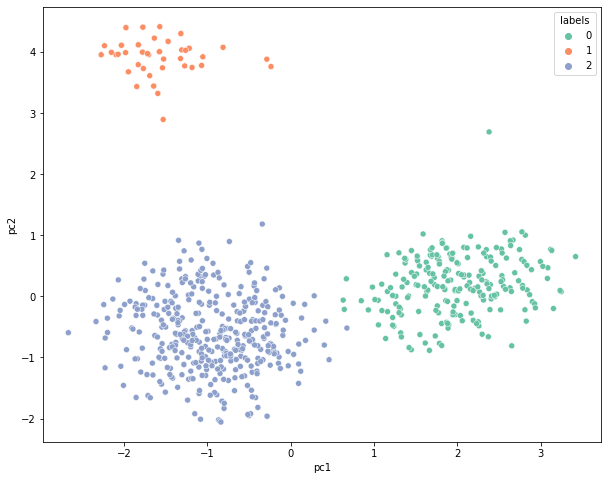

In [35]:
# Second try Hierarchical with 3 clusters as we used above 
model = AgglomerativeClustering(n_clusters=3, affinity='euclidean',  linkage='complete')
model.fit(pca_std)
customer['labels'] = model.labels_
plt.figure(figsize=(10,8))
sns.scatterplot(x=pca_std.pc1, y=pca_std.pc2, hue=customer['labels'], palette="Set2")

### from the graph using PCA followed by clustering we have two oberervation
### 1. Both the clustering algoritms is doing a very good job.
### 2. Both are more than 99% similar. Only one data point is changing clusters in two algorithms

In [36]:
del customer['labels']

In [37]:
customer.head()

,Sl_No,Customer Key,Avg_Credit_Limit,Total_Credit_Cards,Total_visits_bank,Total_visits_online,Total_calls_made,km_labels,h_labels
0,1,87073,100000.0,2,1,1.0,0,1,0
1,2,38414,50000.0,3,0,8.5,9,0,0
2,3,17341,50000.0,7,1,3.0,4,1,2
3,4,40496,30000.0,5,1,1.0,4,1,2
4,5,47437,100000.0,6,0,8.5,3,2,1


In [38]:
display(customer['km_labels'].value_counts())
display(customer['h_labels'].value_counts())

1    386
0    224
2     50
Name: km_labels, dtype: int64

2    386
0    224
1     50
Name: h_labels, dtype: int64

In [39]:
# check out in the original clustering how many points are varying

display(customer[customer['km_labels'] == 0]['h_labels'].value_counts())

display(customer[customer['km_labels'] == 1]['h_labels'].value_counts())

display(customer[customer['km_labels'] == 2]['h_labels'].value_counts())

0    223
2      1
Name: h_labels, dtype: int64

2    385
0      1
Name: h_labels, dtype: int64

1    50
Name: h_labels, dtype: int64

### Here also we confirm that only one data point is changing clusters in two algoritms.
### In the end I will say  both the algoritms did an equally good job.

## Analysis the clusters formed, tell us how is one cluster different from another and answer all the key questions. (10 marks)

### In all the analysis I have used 3 clusters. Both the clusering algoritms have show similar results and the cluster behavior is also similar

### This cluster analysis is done to segment customers mainly based on how they reach out to bank in case of queries and and to some extent based on there average credit limit.  This in turn provides few major opportunities to bank. 

### One , they have the opportunities to target customer for maketing on specfic platform which could be via call, online or in person(when he comes to bank). This will ensure optimal cost utilization and efforts and more success in terms of ROI. 

### Two, bank could allocate adequate resources for customer support for different platforms (call, online etc.) 


## Following are the description and distiction for three clusters:

### Cluster 1 : High End Customer. They have very high average credit limit. The have many cards. They prefer online method of reaching out to bank and maybe online banking also. For such customers bank can mainly focus on Online Marketing. Bank can provide them various offers and for online shopping etc. with discounted offers from credit card to motivate them to use more. Also since they tend to have more cards, bank can propose then more cards with specialized benifits


### Cluster 2 : Medium Customers. They have medium credit limit. They prefer to reach out by going directly to banks and use less of calls and online. For these customers maybe bank can avoid marketing using online and calls which could save them some resources. They can be told of various offers and plans when they visit the bank. Since they use less calls and online maybe they are traditional users or old people. Specialized marketing may be made depending.


### Cluster 3 : Low End customer. They visit the bank less and have moderate online presence. But they use call a lot for their quries. This suggest that bank should use Call based marketing for these types of customer. Also since they have low credit limit, they can be targeted for increase in credit limit based on thier usage pattern and credit score. 